In [1]:
cd ..

/master


In [2]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%load_ext autoreload
#%autoreload 2
#%pdb

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(8)

Autosaving every 600 seconds


# (LARGE) Conditional Neural Process 1D - Gaussian Process Samples

last update: 08 June 2019

**Aim**: This notebook shows how to train and sample from a Conditional Neural Process (no latents) for a simple class of 1D functions. The functions are sampled from a Gaussian process with various kernels.


In [3]:
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, 
                                              DotProduct, ConstantKernel)

from skssl.transformers import NeuralProcessLoss, NeuralProcess
from skssl.predefined import MLP
from skssl.transformers.neuralproc.datasplit import context_target_split

from ntbks_datasets import GPDataset
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

In [4]:
x_dim = 1
y_dim = 1
r_dim = 128
batch_size = 64
num_points = 128
num_samples = 100000
n_epochs = 50


def _DeepMLP(*args):
    return MLP(*args, hidden_size=r_dim, n_hidden_layers=3)


def get_cntxt_trgt(*args):
    return context_target_split(*args,
                                range_cntxts=(3, 50),
                                range_extra_trgts=(num_points-50, num_points-50))


def get_model(x_dim, y_dim):
    return NeuralProcess(x_dim, y_dim,
                         Encoder=_DeepMLP,
                         Decoder=_DeepMLP,
                         r_dim=r_dim,
                         LatentEncoder=MLP,
                         get_cntxt_trgt=get_cntxt_trgt,
                        encoded_path="deterministic")


data_models = dict()
data_models["rbf"] = (get_model(x_dim, y_dim),
                      GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                                 length_scale_bounds=(1e-1, 10.0)),
                                num_samples=num_samples,
                                num_points=num_points))
data_models["periodic"] = (get_model(x_dim, y_dim),
                           GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                                 periodicity=3.0,
                                                                 length_scale_bounds=(0.1, 10.0),
                                                                 periodicity_bounds=(1.0, 10.0)),
                                     num_samples=num_samples,
                                     num_points=num_points))
data_models["non-stationary"] = (get_model(x_dim, y_dim),
                                 GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                                   (DotProduct(sigma_0=1.0,
                                                               sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                           num_samples=num_samples,
                                           num_points=num_points))
data_models["matern"] = (get_model(x_dim, y_dim),
                         GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                       length_scale_bounds=(1e-1, 10.0),
                                                       nu=1.5),
                                   num_samples=num_samples,
                                   num_points=num_points))


##  Data

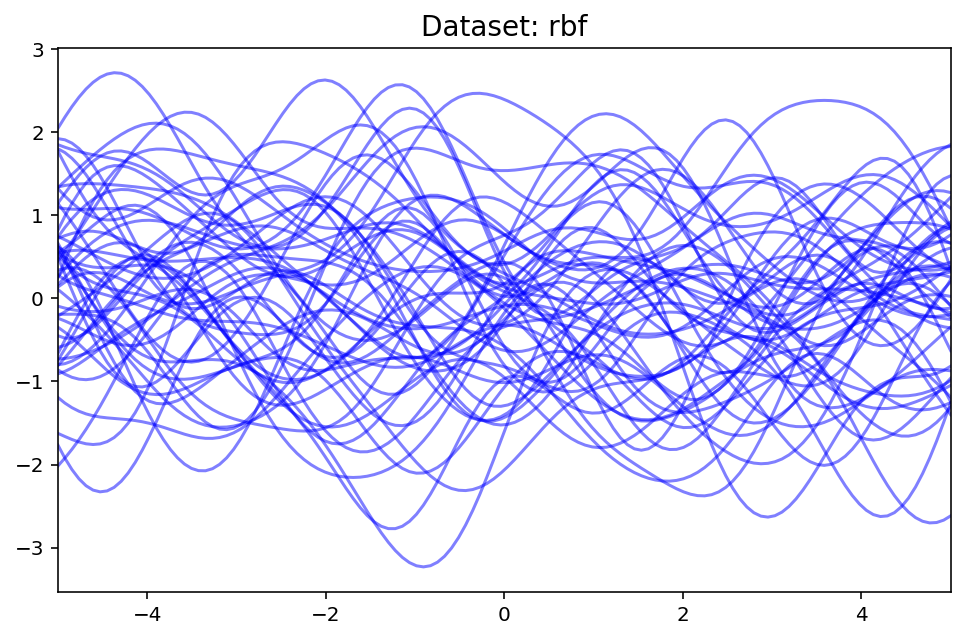

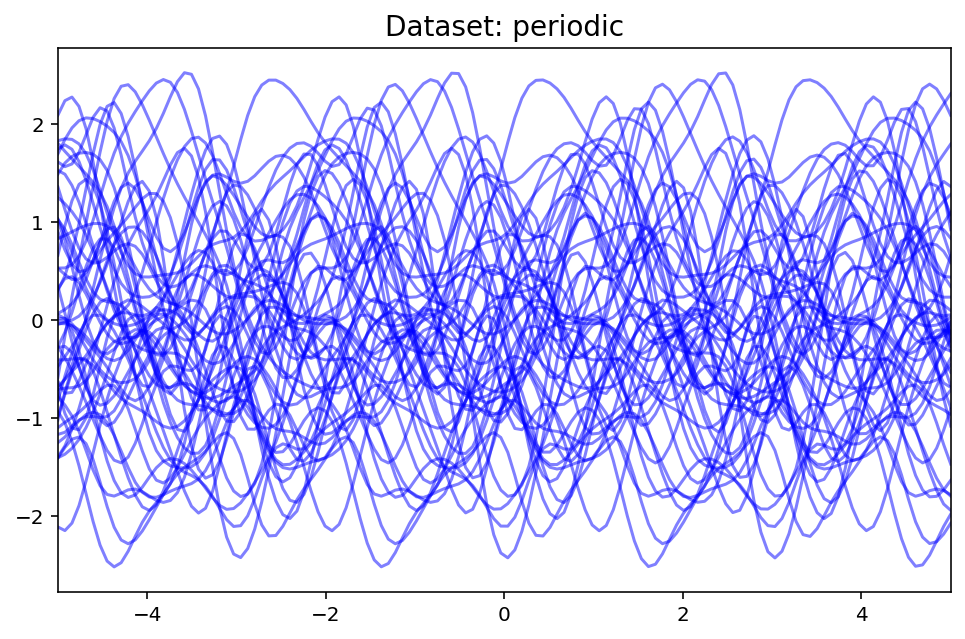

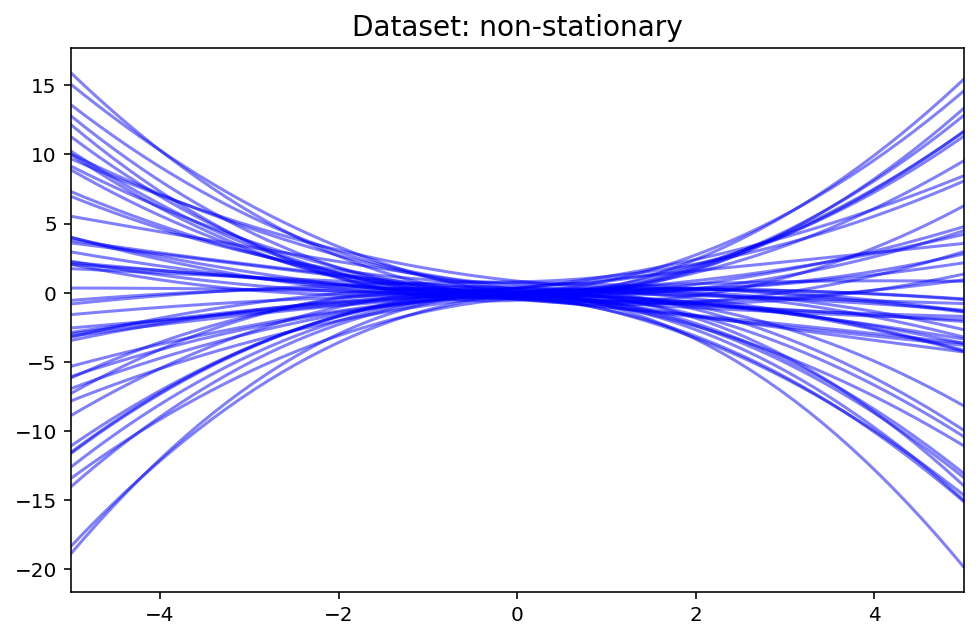

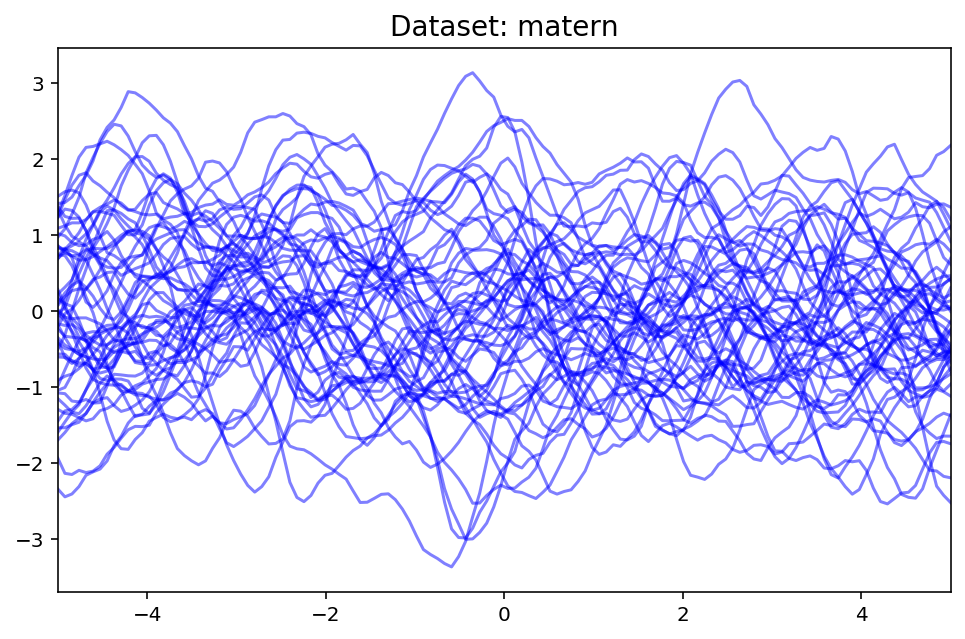

In [5]:
for k,(neural_proc, dataset) in data_models.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Prior Samples

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

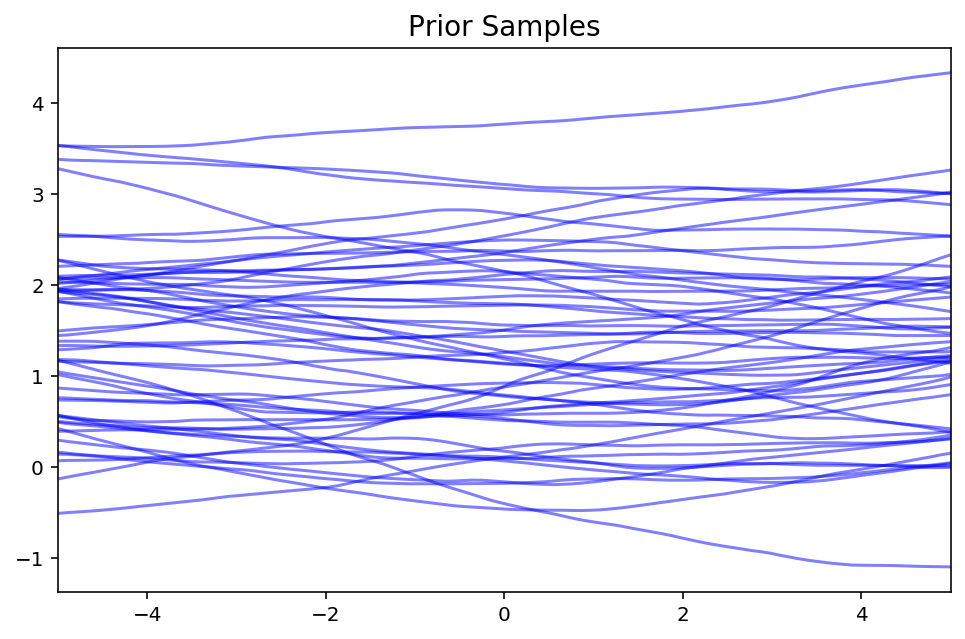

In [6]:
plot_prior_samples(neural_proc, r_dim, min_max=dataset.min_max)

## Training

In [7]:
from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- Training {} ---".format(k))
    print()
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=n_epochs,
                                 batch_size=batch_size,
                                train_split=None) # no dev set
    
    _=model.fit(*make_Xy_input(dataset))


--- Training rbf ---



  epoch    train_loss      dur
-------  ------------  -------
      1      125.0995  11.5584


      2       90.7044  11.3235


      3       67.9532  11.1418


      4       52.2464  11.3574


      5       39.4051  11.2175


      6       29.3250  10.9707


      7       24.5709  11.2632


      8       16.5353  11.2034


      9       10.2363  11.2463


     10        7.1349  12.0690


     11       -1.5279  11.2739


     12       -2.8040  11.4734


     13       -6.3219  9.5226


     14       -8.4266  11.5034


     15      -12.8237  11.5558


     16      -16.9972  11.2578


     17      -16.4708  12.0764


     18      -19.9357  11.2031


     19      -20.8194  11.2463


     20      -21.3402  10.7967


     21      -23.3617  10.2403


     22      -26.5395  11.3616


     23      -30.0561  11.7456


     24      -30.6684  11.9613


     25      -32.7281  10.1016


     26      -33.1910  11.2766


     27      -33.8672  11.3181


     28      -34.9346  10.5682


     29      -33.8713  11.5948


     30      -39.0935  11.9117


     31      -39.4854  11.2046


     32      -41.5288  11.2585


     33      -40.1445  11.6244


     34      -42.9694  9.6152


     35      -45.5862  11.0190


     36      -42.8957  12.7379


     37      -44.9908  10.7968


     38      -45.5889  11.4333


     39      -46.8371  11.6153


     40      -46.0722  11.2587


     41      -45.3126  11.2885


     42      -50.0933  11.2279


     43      -47.9926  11.2484


     44      -48.4978  12.7718


     45      -48.0979  11.5070


     46      -48.1675  10.7720


     47      -48.8989  9.6519


     48      -49.8906  11.3659


     49      -49.6568  11.2910


     50      -50.5176  12.1935

--- Training periodic ---



  epoch    train_loss      dur
-------  ------------  -------
      1      155.7721  11.2245


      2      135.1410  12.1340


      3      133.2998  11.1814


      4      132.6225  10.8045


      5      130.3020  11.2065


      6      127.5456  11.1702


      7      111.7688  11.6704


      8       87.4105  11.3196


      9       74.1479  11.2453


     10       66.7369  11.2242


     11       55.6865  10.4288


     12       47.8194  11.3432


     13       42.9673  11.5802


     14       37.7265  11.3920


     15       33.1965  12.2538


     16       29.8799  9.6799


     17       27.5676  10.8348


     18       23.3393  11.2112


     19       20.1974  11.2180


     20       19.5686  11.4508


     21       17.8363  11.2244


     22       14.2755  11.5427


     23       11.8722  12.0910


     24        8.8560  11.2288


     25        8.1967  11.3451


     26        6.7760  10.9587


     27        5.5603  11.9114


     28        2.7872  11.3457


     29        2.6523  11.3198


     30       -0.6987  12.5464


     31       -2.3828  10.6360


     32       -4.9153  11.7952


     33       -3.7936  11.6429


     34       -6.9340  11.4711


     35       -9.7446  10.6879


     36       -9.1264  10.5690


     37      -11.2337  10.9353


     38      -12.0929  11.6713


     39      -10.5406  11.2294


     40      -10.9817  11.5921


     41      -12.2416  11.4066


     42      -17.6553  10.4089


     43      -16.5701  10.5017


     44      -16.6062  11.8416


     45      -18.3385  11.0728


     46      -18.8555  11.4015


     47      -19.9062  10.6999


     48      -21.1135  11.5237


     49      -21.7368  11.3583


     50      -21.9311  10.9471

--- Training non-stationary ---



  epoch    train_loss      dur
-------  ------------  -------
      1      481.3089  10.8105


      2      115.6470  11.2265


      3       66.4237  11.3821


      4       38.6289  10.9300


      5       21.6013  11.3391


      6        6.7454  11.0425


      7       -8.7118  11.1770


      8      -22.9876  11.6301


      9      -37.0443  11.1285


     10      -48.9054  10.6519


     11      -63.2809  11.2311


     12      -66.6941  11.2385


     13      -69.1029  11.3033


     14      -73.5921  11.0814


     15      -77.7525  11.1293


     16      -86.2924  11.1903


     17      -83.9531  12.1989


     18      -86.0558  12.2568


     19      -86.6082  12.0082


     20      -89.6769  11.6201


     21      -92.0614  10.0756


     22      -95.0152  11.1962


     23      -98.2056  11.3374


     24     -100.5268  11.2130


     25     -100.2060  10.5827


     26     -101.5487  11.4622


     27     -102.1961  11.2550


     28     -103.3214  11.1448


     29     -102.1093  11.3116


     30     -108.2651  11.4418


     31     -104.4326  11.5930


     32     -105.6129  9.8180


     33     -105.8379  9.6837


     34     -109.3892  11.7450


     35     -111.4950  10.6686


     36     -107.6736  11.0169


     37     -111.8238  10.5324


     38     -110.9896  10.2905


     39     -112.4905  10.3923


     40     -110.8588  11.2994


     41     -112.7836  11.4072


     42     -116.5194  10.5019


     43     -116.3109  11.5098


     44     -113.8656  11.1624


     45     -114.7237  11.8193


     46     -114.5029  10.9489


     47     -114.9780  9.6515


     48     -115.8219  10.5218


     49     -118.7168  11.3872


     50     -117.9974  12.4806

--- Training matern ---



  epoch    train_loss      dur
-------  ------------  -------
      1      140.8247  10.7656


      2      117.8616  11.5473


      3      103.5749  11.1556


      4       92.8825  11.1554


      5       84.8140  11.3623


      6       78.6437  11.1689


      7       74.8600  11.4171


      8       69.9286  10.6506


      9       65.7711  11.2439


     10       63.8496  11.5905


     11       58.0304  11.1609


     12       56.8921  11.1895


     13       55.1497  10.6772


     14       52.9144  11.1552


     15       51.0127  10.9874


     16       47.5899  11.4255


     17       47.4526  11.6775


     18       45.7247  11.1236


     19       44.9781  11.1183


     20       44.9792  11.1735


     21       43.2116  11.5183


     22       41.3539  11.2199


     23       38.5739  11.2366


     24       39.0274  11.4087


     25       37.3548  11.3593


     26       37.2228  11.2782


     27       36.7004  11.3185


     28       35.2368  11.4961


     29       36.3539  10.9427


     30       32.7366  9.7500


     31       33.4492  11.3544


     32       31.6691  11.5596


     33       33.1793  11.9682


     34       29.6098  10.9435


     35       28.4894  11.6391


     36       30.6094  11.5820


     37       29.3997  11.3271


     38       28.9022  11.6985


     39       27.8372  12.2015


     40       28.3572  11.1789


     41       28.8304  11.2352


     42       24.8592  11.6931


     43       26.2255  11.6991


     44       26.6153  11.4637


     45       25.9248  10.3975


     46       26.1340  11.8195


     47       25.9049  11.5975


     48       25.0726  11.3655


     49       25.4662  12.3695


     50       24.9816  11.2431


## Trained Prior 
The prior should now encode some information about the shapes of the functions.

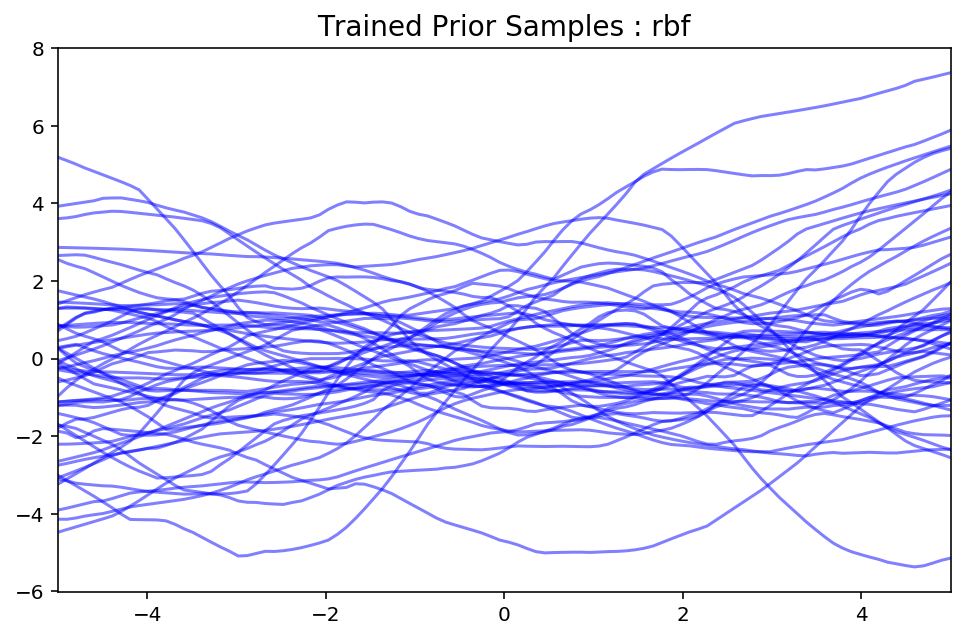

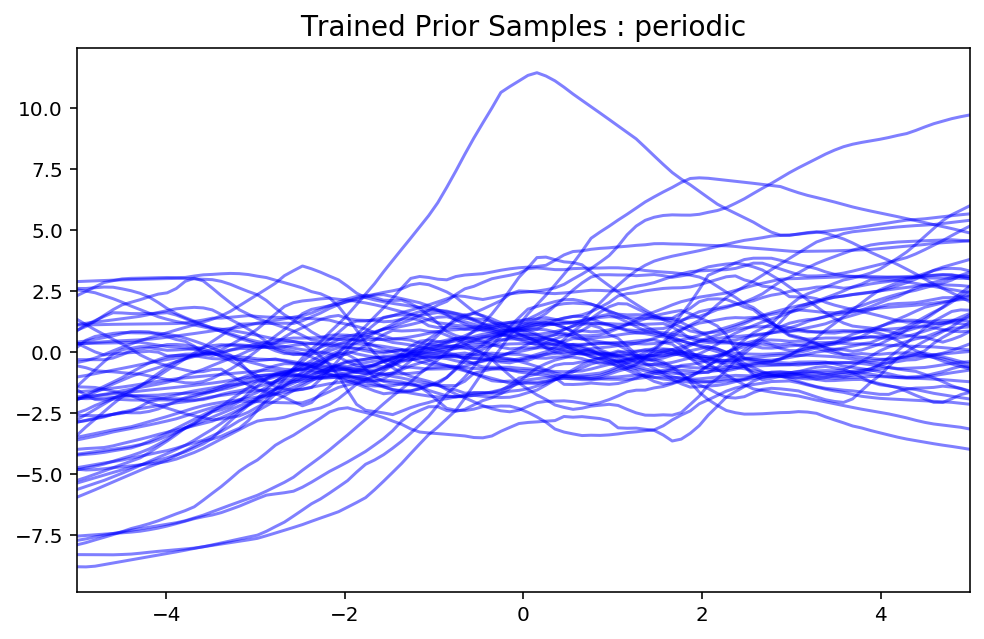

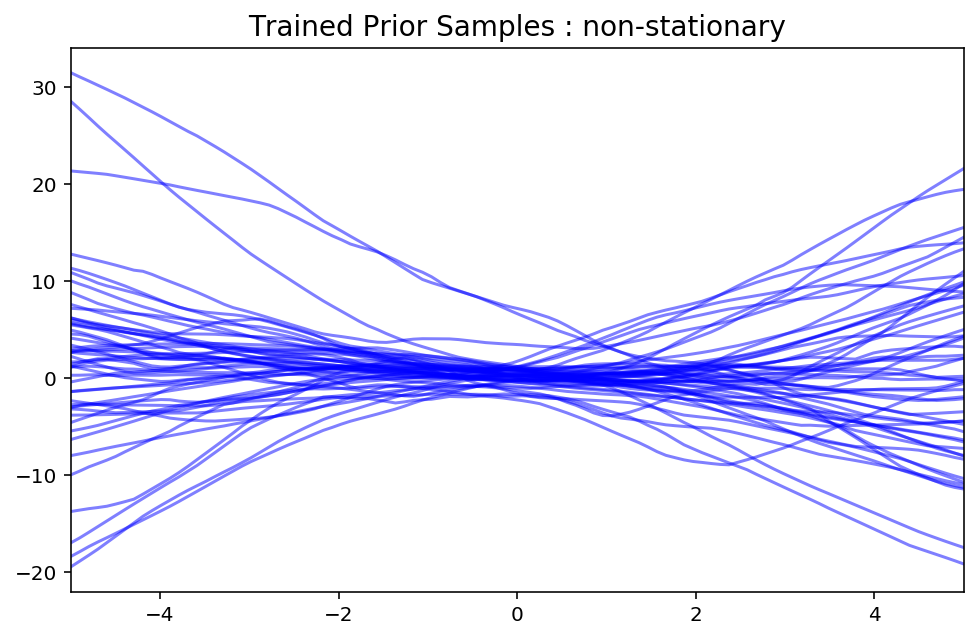

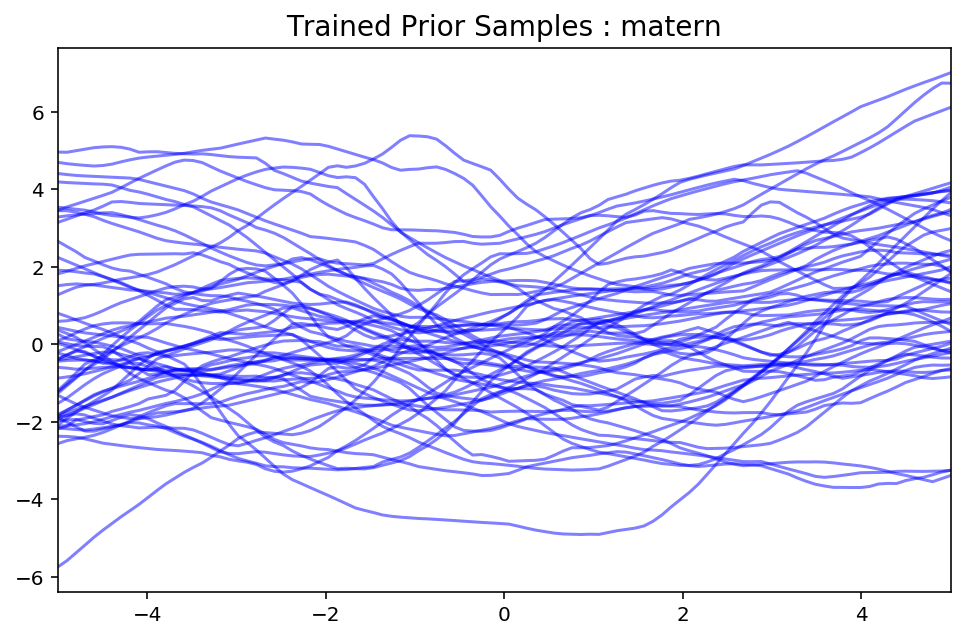

In [8]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, r_dim, title="Trained Prior Samples : {}".format(k))

## Posterior

std: 0.36458957
std: 0.26717022
std: 0.14758049
std: 0.43431872


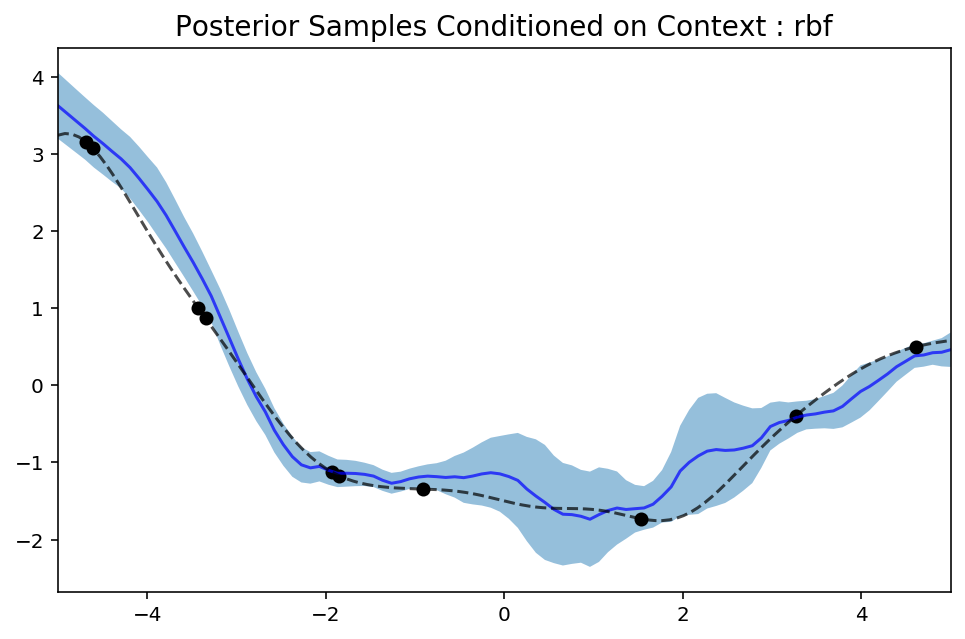

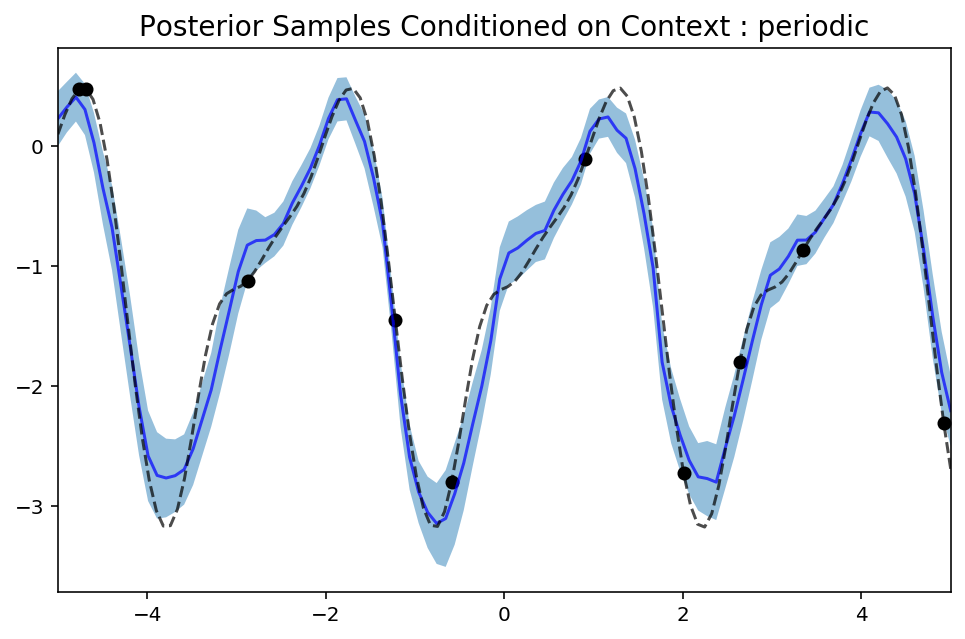

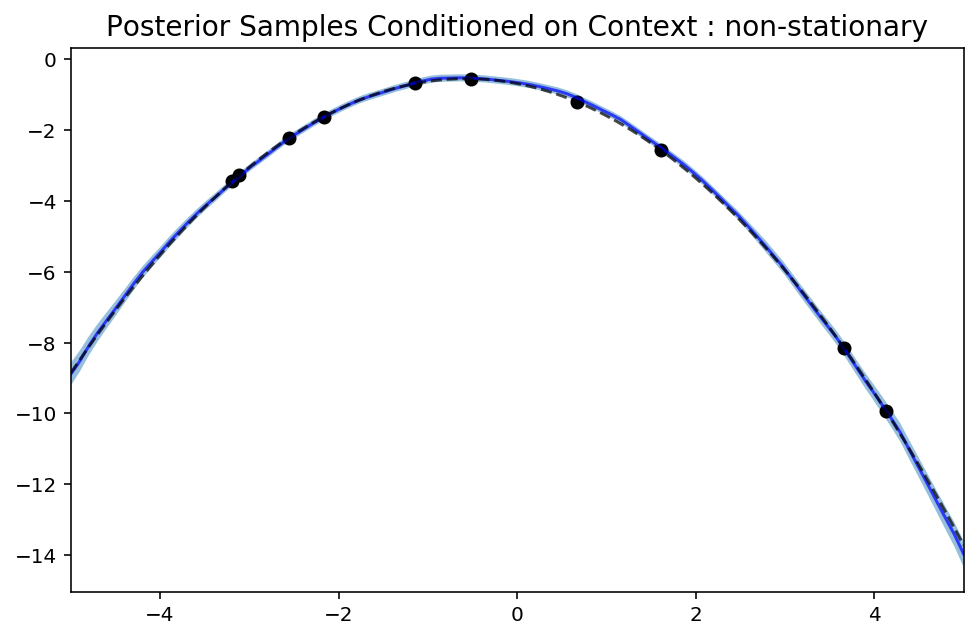

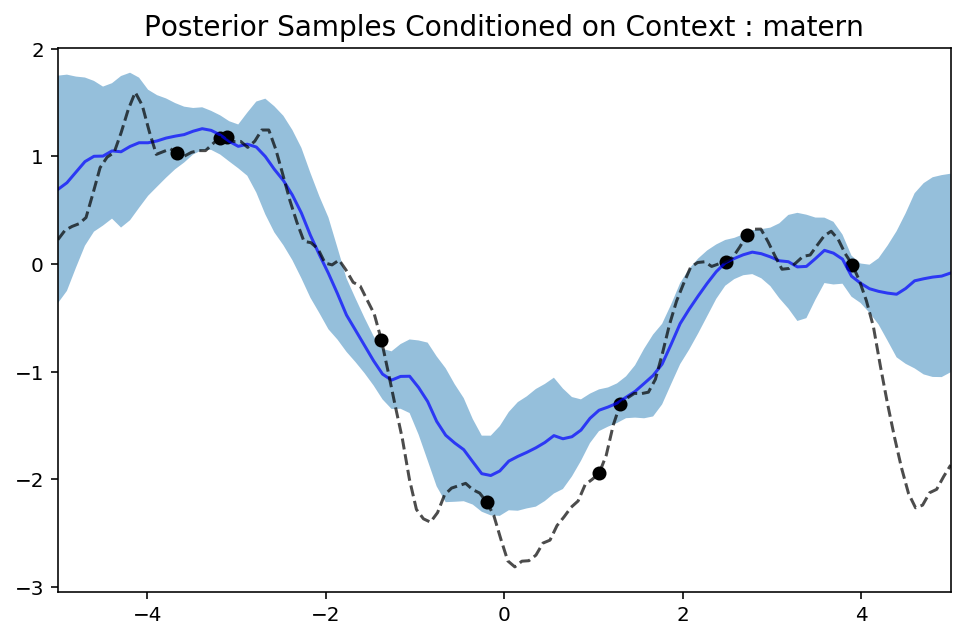

In [9]:
n_cntxt = 10

for k,(neural_proc, dataset) in data_models.items():
    
    for X, Y in model.get_iterator(dataset, training=False):
        break
    X, Y = X[0:1], Y[0:1]
    n_points = X.size(1)
    idx = torch.randperm(n_points)[:n_cntxt]
    X_cntxt, Y_cntxt = X[:,idx,:], Y[:,idx,:]
    
    plot_posterior_samples(neural_proc, X_cntxt, Y_cntxt, true_func=(X,Y),  n_samples=1, is_plot_std=True,
                           title="Posterior Samples Conditioned on Context : {}".format(k))

Let's now use a single context point to see how much information is in the "learned implicit kernel"

std: 1.0065862
std: 1.1852748
std: 2.0030997
std: 1.035978


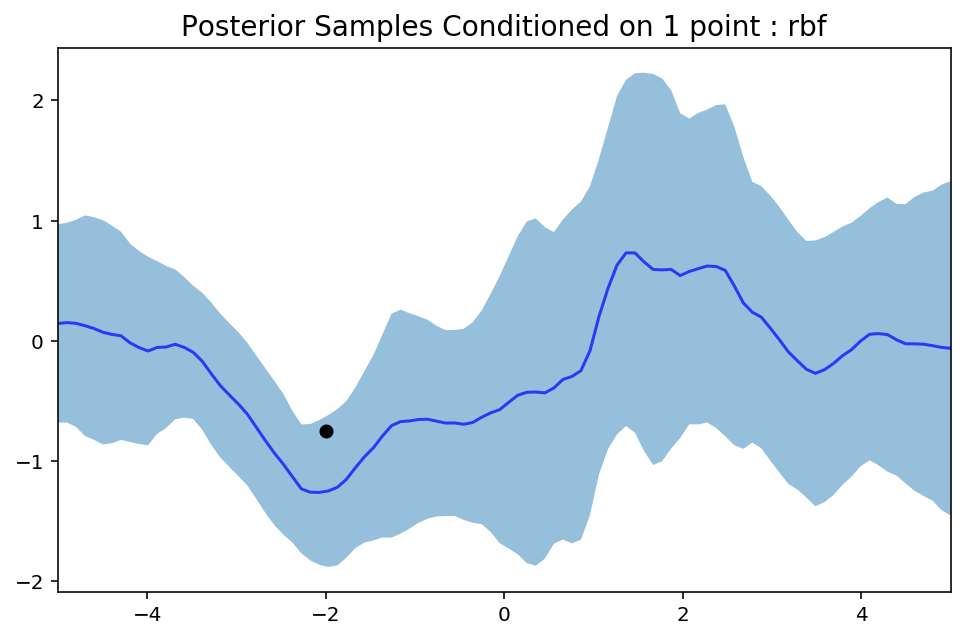

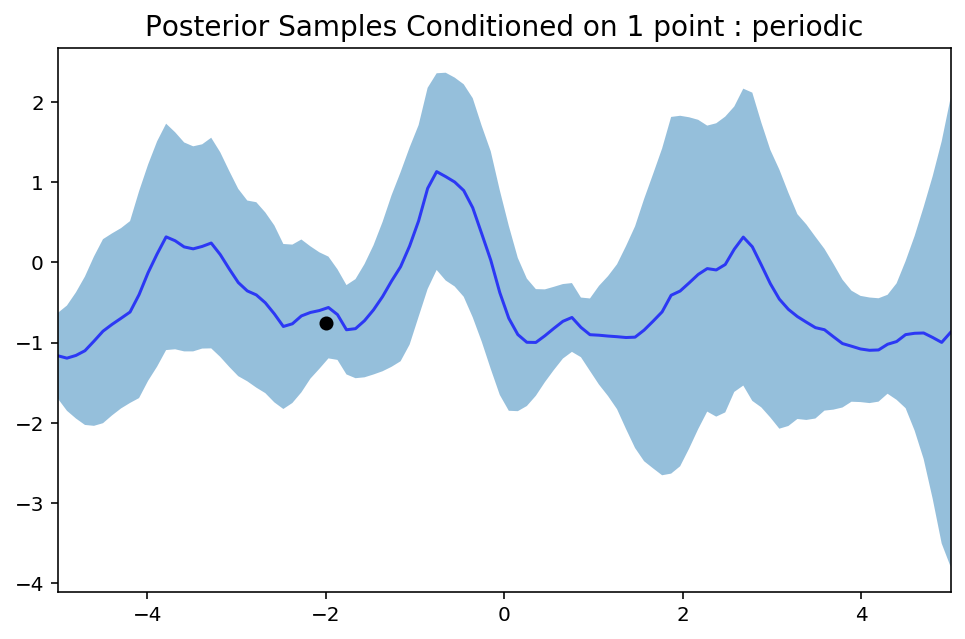

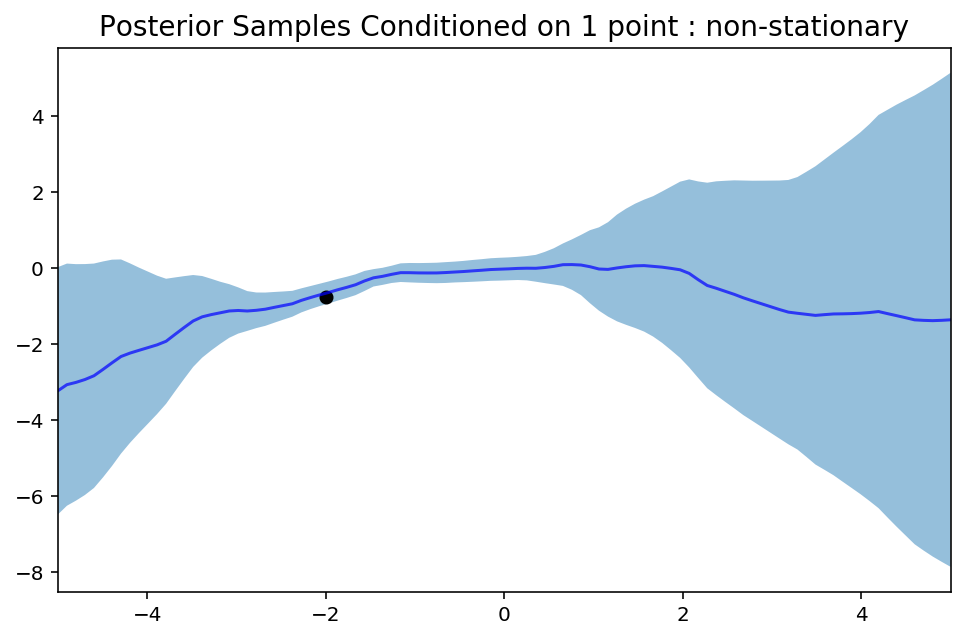

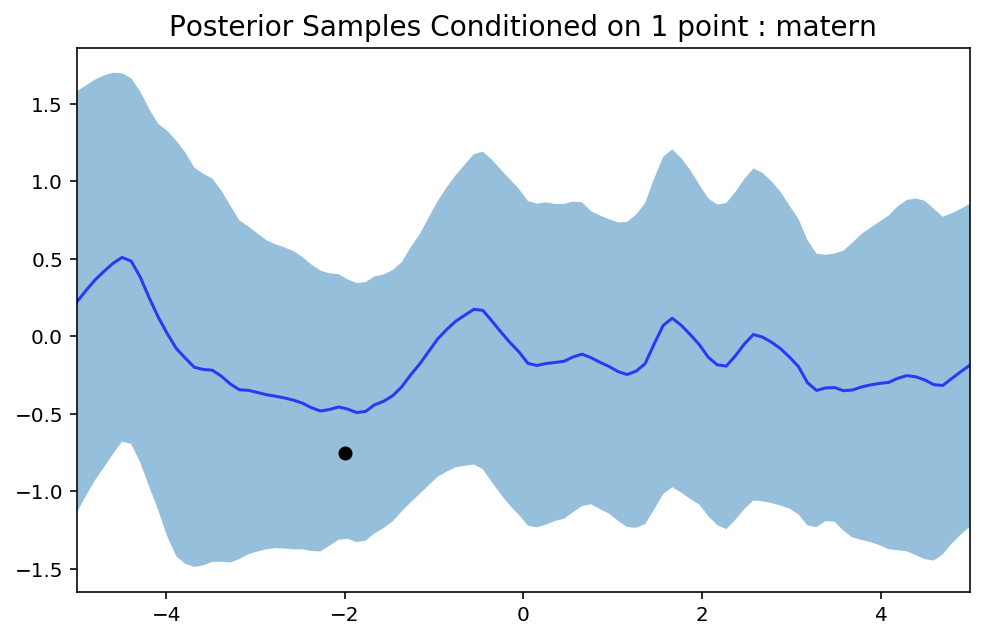

In [10]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[-0.75]]]),  
                           is_plot_std=True, n_samples=1,
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))

std: 0.7426429
std: 0.97498804
std: 1.7919225
std: 1.0019902


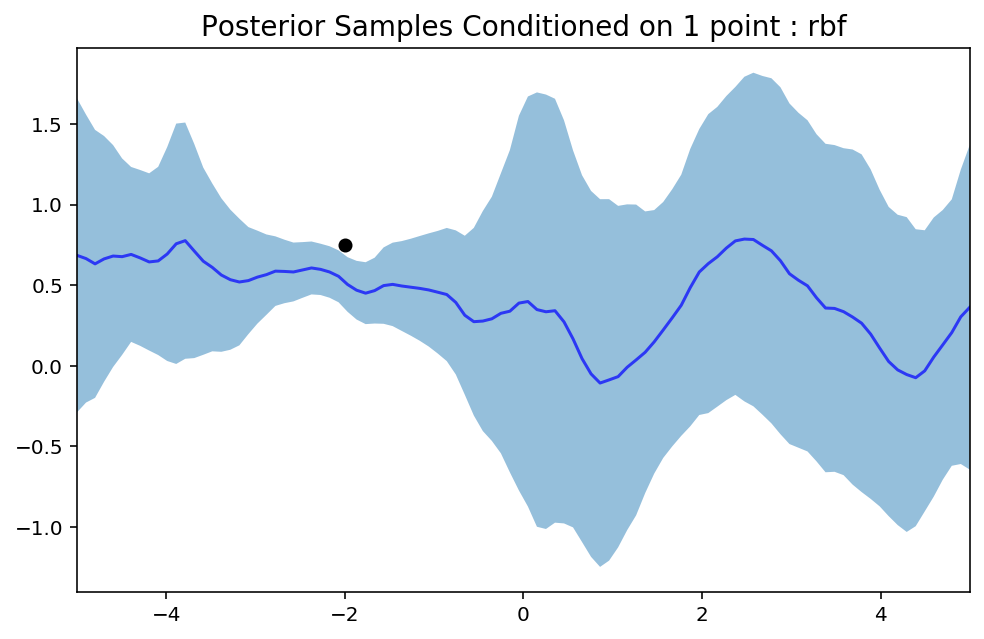

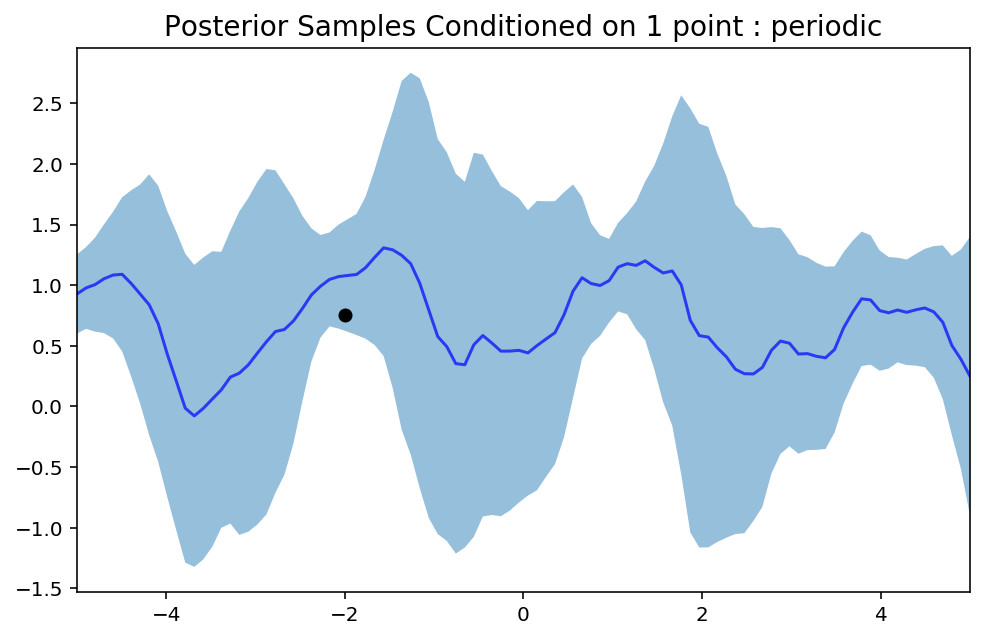

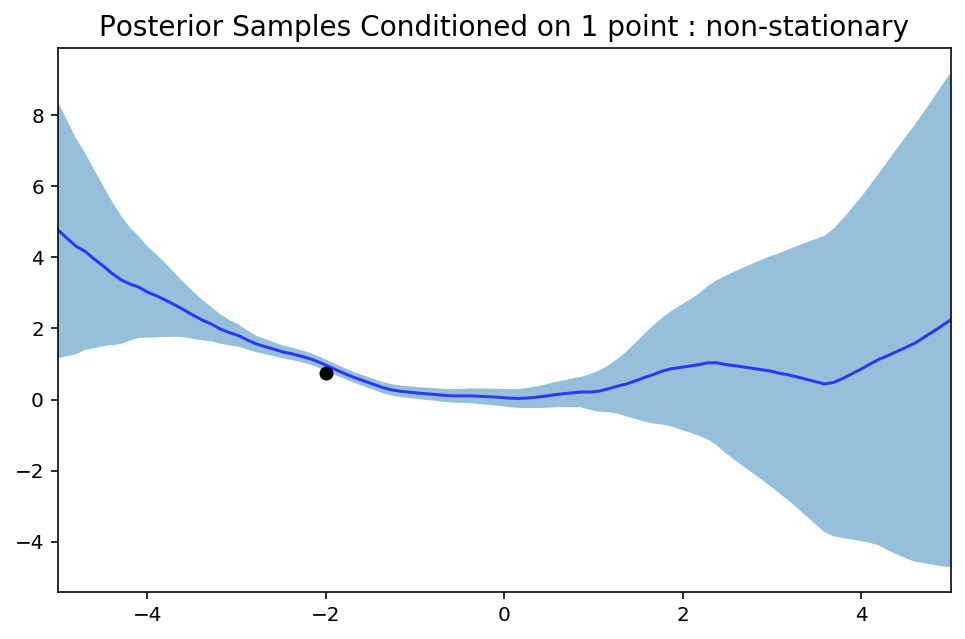

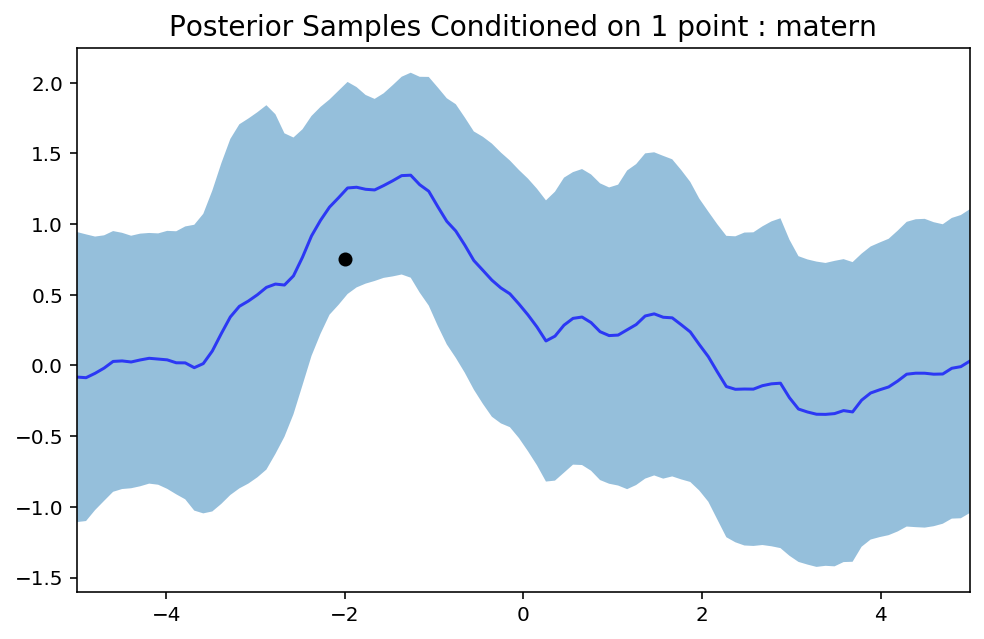

In [11]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[0.75]]]), 
                           is_plot_std=True, n_samples=1,
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))